In [1]:
# 获取Google网盘的访问权限

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
from random import shuffle
import matplotlib.pyplot as plt

In [0]:
# 获取训练集并对训练集的图像进行reshape

train_txt_path = './gdrive/My Drive/remote/RSDataset/train.txt'
img = []
train_imgs = [];
train_label = []
fh = open(train_txt_path, 'r')
for line in fh:
    line = line.rstrip()
    words = line.split()
    img = Image.open(words[0]+' '+words[1]).convert('RGB');
    img = img.resize((40,40))
    img = np.array(img)
    train_imgs.append(img)
    train_label.append(int(words[2]))
    # X.append(Image.open(words[0]+' '+words[1]).convert('RGB'))
train_imgs = np.array(train_imgs)
train_label = np.array(train_label)
train_imgs = np.reshape(train_imgs, (train_imgs.shape[0], -1))

In [0]:
# 获取测试集并对测试集的图像进行reshape

test_txt_path = './gdrive/My Drive/remote/RSDataset/test.txt'
img = []
test_imgs = [];
test_label = []
fh = open(test_txt_path, 'r')
for line in fh:
    line = line.rstrip()
    words = line.split()
    img = Image.open(words[0]+' '+words[1]).convert('RGB');
    img = img.resize((40,40))
    img = np.array(img)
    test_imgs.append(img)
    test_label.append(int(words[2]))
    # X.append(Image.open(words[0]+' '+words[1]).convert('RGB'))
test_imgs = np.array(test_imgs)
test_label = np.array(test_label)
test_imgs = np.reshape(test_imgs, (test_imgs.shape[0], -1))

In [0]:
# 减去mean image

mean_image = np.mean(train_imgs, axis=0, dtype = np.uint8)
train_imgs -= mean_image
test_imgs -= mean_image
train_imgs = np.hstack([train_imgs, np.ones((train_imgs.shape[0], 1))])
test_imgs = np.hstack([test_imgs, np.ones((test_imgs.shape[0], 1))])

In [0]:
# 建立LinearClassifier类和LinearSVM类

class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      mask = np.random.choice(num_train, batch_size, replace=False)
      X_batch = X[mask]
      y_batch = y[mask]  

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      self.W = self.W - learning_rate * grad

      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):

    y_pred = np.zeros(X.shape[1])
    y_pred = np.argmax(np.dot(X,self.W), axis=1)  
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    pass
  
  


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """
  
  def loss(self, X, y, reg):
    W = self.W
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    scores = X.dot(W)        
    num_classes = W.shape[1]
    num_train = X.shape[0]

    scores_correct = scores[np.arange(num_train), y]   # 1 by N
    scores_correct = np.reshape(scores_correct, (num_train, -1))  # N by 1
    margins = scores - scores_correct + 1    # N by C
    margins = np.maximum(0,margins)
    margins[np.arange(num_train), y] = 0
    loss += np.sum(margins) / num_train
    loss += 0.5 * reg * np.sum(W * W)

    # compute the gradient
    margins[margins > 0] = 1
    row_sum = np.sum(margins, axis=1)                  # 1 by N
    margins[np.arange(num_train), y] = -row_sum        
    dW += np.dot(X.T, margins)/num_train + reg * W     # D by C
    return loss, dW

iteration 0 / 2500: loss 1227.069402
iteration 100 / 2500: loss 706.532755
iteration 200 / 2500: loss 427.325187
iteration 300 / 2500: loss 260.862477
iteration 400 / 2500: loss 157.881272
iteration 500 / 2500: loss 98.230295
iteration 600 / 2500: loss 61.349559
iteration 700 / 2500: loss 38.918240
iteration 800 / 2500: loss 24.926078
iteration 900 / 2500: loss 18.563941
iteration 1000 / 2500: loss 12.572836
iteration 1100 / 2500: loss 10.906719
iteration 1200 / 2500: loss 9.010978
iteration 1300 / 2500: loss 7.850143
iteration 1400 / 2500: loss 6.563223
iteration 1500 / 2500: loss 8.966493
iteration 1600 / 2500: loss 9.359344
iteration 1700 / 2500: loss 5.164979
iteration 1800 / 2500: loss 5.567070
iteration 1900 / 2500: loss 6.786180
iteration 2000 / 2500: loss 10.271308
iteration 2100 / 2500: loss 7.517442
iteration 2200 / 2500: loss 5.463360
iteration 2300 / 2500: loss 6.120511
iteration 2400 / 2500: loss 5.273283
linear SVM on raw pixels final test set accuracy: 0.203883


Text(0, 0.5, 'Loss value')

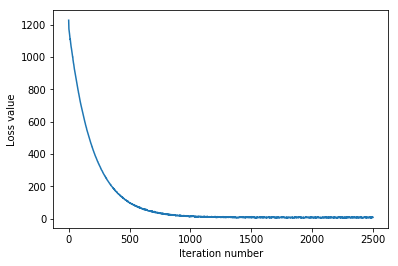

In [7]:
# 实例化SVM分类器并进行训练

svm = LinearSVM()
loss_hist = svm.train(train_imgs, train_label, learning_rate=1e-7, reg=2.5e4,num_iters=2500, verbose=True)

test_pred = svm.predict(test_imgs)
test_accuracy = np.mean(test_pred == test_label)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [8]:
# 尝试不同的学习率和正则化参数对训练结果的影响

learning_rate = [1e-8, 1e-7, 1e-6]
regularization = [1e4, 2.5e4, 5e4]
accuracy = { }
for i,lr in enumerate(learning_rate):
  for j, reg in enumerate(regularization):
    svm = LinearSVM()
    loss_hist = svm.train(train_imgs, train_label, learning_rate=1e-7, reg=2.5e4,num_iters=2500, verbose=True)
    test_pred = svm.predict(test_imgs)
    test_accuracy = np.mean(test_pred == test_label)
    accuracy[(lr, reg)] = test_accuracy

iteration 0 / 2500: loss 1224.263021
iteration 100 / 2500: loss 702.653539
iteration 200 / 2500: loss 425.129947
iteration 300 / 2500: loss 257.918081
iteration 400 / 2500: loss 160.787767
iteration 500 / 2500: loss 96.913571
iteration 600 / 2500: loss 63.465235
iteration 700 / 2500: loss 41.674763
iteration 800 / 2500: loss 26.269613
iteration 900 / 2500: loss 21.107747
iteration 1000 / 2500: loss 11.951840
iteration 1100 / 2500: loss 12.094448
iteration 1200 / 2500: loss 8.465486
iteration 1300 / 2500: loss 6.458081
iteration 1400 / 2500: loss 6.598347
iteration 1500 / 2500: loss 12.766123
iteration 1600 / 2500: loss 5.613541
iteration 1700 / 2500: loss 5.799943
iteration 1800 / 2500: loss 9.466316
iteration 1900 / 2500: loss 6.271964
iteration 2000 / 2500: loss 9.332471
iteration 2100 / 2500: loss 6.577226
iteration 2200 / 2500: loss 8.402079
iteration 2300 / 2500: loss 8.749098
iteration 2400 / 2500: loss 5.537835
iteration 0 / 2500: loss 1212.376795
iteration 100 / 2500: loss 701.

In [9]:
for lr, reg in sorted(accuracy):
  test_accuracy = accuracy[(lr, reg)]
  print('lr %e reg %e test accuracy: %f' % (lr, reg, test_accuracy))

lr 1.000000e-08 reg 1.000000e+04 test accuracy: 0.140777
lr 1.000000e-08 reg 2.500000e+04 test accuracy: 0.271845
lr 1.000000e-08 reg 5.000000e+04 test accuracy: 0.203883
lr 1.000000e-07 reg 1.000000e+04 test accuracy: 0.237864
lr 1.000000e-07 reg 2.500000e+04 test accuracy: 0.291262
lr 1.000000e-07 reg 5.000000e+04 test accuracy: 0.169903
lr 1.000000e-06 reg 1.000000e+04 test accuracy: 0.276699
lr 1.000000e-06 reg 2.500000e+04 test accuracy: 0.233010
lr 1.000000e-06 reg 5.000000e+04 test accuracy: 0.165049


iteration 0 / 2500: loss 1237.319872
iteration 100 / 2500: loss 696.905189
iteration 200 / 2500: loss 422.381975
iteration 300 / 2500: loss 256.217234
iteration 400 / 2500: loss 157.884337
iteration 500 / 2500: loss 98.251800
iteration 600 / 2500: loss 61.526121
iteration 700 / 2500: loss 40.234253
iteration 800 / 2500: loss 29.078409
iteration 900 / 2500: loss 19.375997
iteration 1000 / 2500: loss 12.462659
iteration 1100 / 2500: loss 13.214933
iteration 1200 / 2500: loss 10.398546
iteration 1300 / 2500: loss 6.761459
iteration 1400 / 2500: loss 6.994033
iteration 1500 / 2500: loss 5.856631
iteration 1600 / 2500: loss 6.572297
iteration 1700 / 2500: loss 5.348301
iteration 1800 / 2500: loss 4.852631
iteration 1900 / 2500: loss 8.238075
iteration 2000 / 2500: loss 4.456639
iteration 2100 / 2500: loss 7.288373
iteration 2200 / 2500: loss 8.055703
iteration 2300 / 2500: loss 5.939402
iteration 2400 / 2500: loss 7.988366


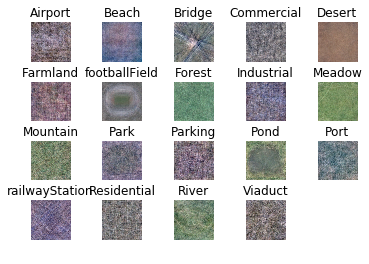

In [11]:
# 可视化SVM的权值矩阵

svm = LinearSVM()
loss_hist = svm.train(train_imgs, train_label, learning_rate=1e-7, reg=2.5e4,num_iters=2500, verbose=True)

w = svm.W[:-1,:] # strip out the bias
w = w.reshape(40, 40, 3, 19)
w_min, w_max = np.min(w), np.max(w)
classes = ['Airport','Beach','Bridge','Commercial','Desert','Farmland','footballField','Forest','Industrial','Meadow',
           'Mountain','Park','Parking','Pond','Port','railwayStation','Residential','River','Viaduct']
for i in range(19):
    plt.subplot(4, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
    plt.subplots_adjust(wspace =0.5, hspace =0.5) #调整子图间距